# General Public License Disclaimer

    Script to run ribosome analysis
    Copyright (C) 2019  Fuad Mohammad, fuadm424@gmail.com


    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

# FASTQ processing script

This notebook will take FASTQ files from Ribo-seq or RNA-seq and convert them to density files aligned to a genome using the 3' end of reads. 

- Filtering is done using skewer v0.2.2 to remove low quality reads and reads outside of size threshold.
- Bowtie v0.12.7 is used to remove any contaminating ladder, tRNA, and rRNA reads ny making indices for all tRNAs, rRNA, and ladder sequences separately. Aligns reads with an allowed mismatch of 2.
- Density is made using 3' alignment. It is stored as a pickled dictionary and is size separated. It is also saved as a .wig file and a .bin file for convenience. 
- Script will output library statistics including filtering and bowtie read allocation, as well as some custom QC information. 

Input and paths are placed in dictionaries. Libraries are numbered as initials + library number (FM1, FM2...)

# Settings


In [1]:
%load_ext autoreload
%autoreload 2
import ribo_util
import ribo_main
import ribo_analysis
import ribo_plot
import pandas as pd



'''Files and Input Settings'''

path_pc     = '/Volumes/HDD/Mohammad_2018/'  # location of folder for ribosome profiling
                                             # should have subfolder '/libraries/FASTQ/' containing FASTQ file
                                             # should have subfolder '/annotations/Coli/' containing GFF
        
path_script = '/Users/fuad/Dropbox/scripts/' # Location of the pipeline scripts

# File names can be manually added to list, or read as .csv with header == Library
# Library names must be the same as the fastq file name

all_files  = []                              # sample name, same as FASTQ filename
file_csv   = path_pc  + 'Library_names.csv'  # alternatively, provide .csv with filenames

library_id = pd.read_csv(file_csv)

for fname in library_id.Library:
    all_files.append(fname)
    
# inputs dict will have all input info used in FASTQ processing

inputs = {
    
    'files' : all_files,                     # Files to analyze
    'data_type'  : 'ribo_seq',               # Type of library: ribo_seq or RNA_seq
    
    # select which functions to run: 'yes' and 'no' 
    'run_filtering'         : 'yes',
    'run_filter_UMI'        : 'no' ,         # set to yes only if using UMI (Unique Molecular Identifiers)
    'run_bowtie'            : 'yes',
    'run_density'           : 'yes',
    'run_readQC'            : 'yes',
    
    # cuttoff for read length and quality
    'minlength'    : 15,
    'maxlength'    : 45,
    'phred_cutoff' : 10,
    
    # linker sequence to be removed during filtering                        
    'linker'       :   'CTGTAGGCACCATCAATAGATCGGAAGAGCACACGTCTGAACTCCAGTCA',
                      
    # UMI lengths, ignore if UMIs are not used
    'linker_UMI'   : 0, 
    'RT_UMI'       : 0,
    
    # CPU information for multithreading applications, 
    'multiprocess' : 'yes',
    'threads'      : 8,
    'cores'        : 4,     
    }


['CW63']


In [2]:
'''Input directories'''

# Can be customized to your liking 


# paths_in must be created prior to running, and filled with the relevant files:
paths_in = {
    'path_fastq'      : path_pc + 'libraries/FASTQ/',                             # location of FASTQ files    
    'path_bowtie'    : path_script + 'ribo_seq/bowtie/bowtie',                    # location of bowtie
    'btindex_ladder' : path_script + 'ribo_seq/bowtie/indexes/ladder/ladder',     # bowtie index for ladders used in profiling
    'btindex_trna'   : path_script + 'ribo_seq/bowtie/indexes/Coli/Coli_tRNA',    # bowtie index for tRNA
    'btindex_rrna'   : path_script + 'ribo_seq/bowtie/indexes/Coli/Coli_rRNA',    # bowtie index for rRNA
    'btindex_chr'    : path_script + 'ribo_seq/bowtie/indexes/Coli/Coli_genome',  # bowtie index for genome
    }

# Output directories
paths_out = {
    'path_filter'       : path_pc  + 'libraries/density/filtering_bowtie/filterdata/',
    'path_ladder'       : path_pc  + 'libraries/density/filtering_bowtie/alignments/ladder/',
    'path_trna'         : path_pc  + 'libraries/density/filtering_bowtie/alignments/tRNA/',
    'path_rrna'         : path_pc  + 'libraries/density/filtering_bowtie/alignments/rRNA/',
    'path_chr'          : path_pc  + 'libraries/density/filtering_bowtie/alignments/chr/',
    'path_temp'         : path_pc  + 'libraries/density/filtering_bowtie/tmpds/',
    'path_density'      : path_pc  + 'libraries/density/density/',
    'path_log'          : path_pc  + 'libraries/density/logs/',
    'path_analysis_log' : path_pc  + 'libraries/analysis/logs/',
    'path_analysis'     : path_pc  + 'libraries/analysis/individual/',
    'path_figures'      : path_pc  + 'libraries/figures/',
    }

# Check inputs, create output paths, and make gff dictionary if needed
step = 'density'                                 # density or analysis
ribo_util.check_inputs(inputs, paths_in, step)   # will remove file from analysis for not having a FASTQ file
ribo_util.createpath(inputs, paths_out)          # create output paths


In [3]:
filterreads  = ribo_main.run_filter(inputs, paths_in, paths_out)
remove_UMI   = ribo_main.run_filter_UMI(inputs, paths_in, paths_out)
bowtiereads  = ribo_main.run_align(inputs, paths_in, paths_out)
densityreads = ribo_main.run_density(inputs, paths_in, paths_out)
analyzereads = ribo_analysis.readQC(inputs, paths_in, paths_out)

-----FILTER-----

Files to filter: CW63
Filter parameters are: 
min length = 15 
max length = 45 
phred cutoff = 10 

	Started filtering at 2019-05-29 05:44:48.536525
	Finished filtering at 2019-05-29 05:45:32.867782
	COMPLETED FILTERING

	Started UMI removal at 2019-05-29 05:45:32.868485
CW63will not be filtered for a UMI
	Finished UMI removal at 2019-05-29 05:45:32.868618
	COMPLETED UMI REMOVAL

------ALIGN------

Files to align: CW63

	Started Bowtie alignment at 2019-05-29 05:45:32.869351
	Finished ladder removal at 2019-05-29 05:49:39.155360
	Finished tRNA removal at 2019-05-29 05:56:31.425884
	Finished rRNA removal at 2019-05-29 06:03:40.100346
	Finished chromosome alignment at 2019-05-29 06:07:13.849068
	COMPLETED ALIGNING

-----DENSITY-----

Files to condense: CW63

	Started density at 2019-05-29 06:07:13.850185
	Finished density at 2019-05-29 06:09:58.285403
	COMPLETED DENSITY

	Started readQC at 2019-05-29 06:09:58.304155
	Finished readQC at 2019-05-29 06:13:36.597788


# Read analysis 

Read allocation after filtering and bowtie alignment:

,CW63
total_reads,36601050
filtered_reads,31373629
ladder,114019
tRNA,8184259
rRNA,1901308
chromosome,20143914
% Total mapped,55
unaligned,1030129


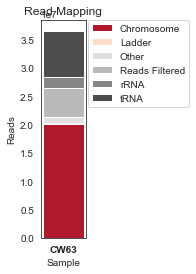

In [4]:
log_data = ribo_util.get_filter_bowtie_log(inputs, paths_in, paths_out)
ribo_plot.plot_alignment_allocation(inputs, paths_in, paths_out)

Read size distribution:

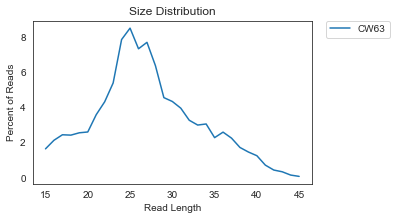

In [5]:
read_size_distribution = ribo_plot.size_dist(inputs, paths_in, paths_out)

Average nucleotide composition of reads:

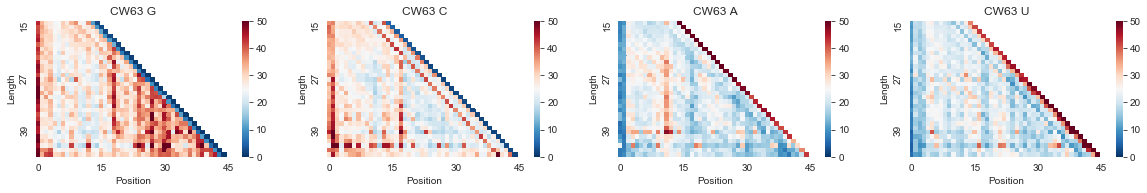

In [6]:
read_composition = ribo_plot.read_comp(inputs, paths_in, paths_out)    